In [2]:
import pickle as pk
from imdb_indexer import word2index
import numpy as np
import pandas as pd
import itertools
import os
from functions import make_ngram, uptoNgram
import tqdm
import matplotlib.pyplot as plt
from bow import BagOfWords, test_model


In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset

class IMDbDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

## setting: 
### nltk tokenization, 1+2-gram, vocab_size =50000,  emb_size = 300, adam optimizer, learning rate = 0.001, max sentence length = 90 percentile of training feature length

In [4]:
ngram_dct = pk.load(open("ngram_dct_nltk.pk", "rb"))
train_label = pk.load(open("train_label.pk", "rb"))
test_label = pk.load(open("test_label.pk", "rb"))
val_label = pk.load(open("val_label.pk", "rb"))

In [9]:
#create upto2gram_nltk first
upto2gram = uptoNgram(2, ngram_dct)

In [10]:
upto2gram.keys()

dict_keys(['train', 'val', 'test'])

In [11]:
train_features = upto2gram['train']
val_features = upto2gram['val']
test_features = upto2gram['test']

In [17]:
print(train_features[1])

['hear', 'prais', 'thi', 'play', 'decid', 'watch', 'stumbl', 'across', 'cabl', 'see', 'thi', 'eliv', 'women', 'struggl', 'focus', 'topic', 'hand', 'guess', 'interest', 'stori', 'women', 'privat', 'part', 'affect', 'live', 'thi', 'otherwis', 'rather', 'dull', 'bore', 'anyth', 'found', 'bit', 'br', 'br', 'inquir', 'femal', 'friend', 'also', 'watch', 'thi', 'thought', 'wa', 'horribl', 'well', 'guy', 'get', 'hear prais', 'prais thi', 'thi play', 'play decid', 'decid watch', 'watch stumbl', 'stumbl across', 'across cabl', 'cabl see', 'see thi', 'thi eliv', 'eliv women', 'women struggl', 'struggl focus', 'focus topic', 'topic hand', 'hand guess', 'guess interest', 'interest stori', 'stori women', 'women privat', 'privat part', 'part affect', 'affect live', 'live thi', 'thi otherwis', 'otherwis rather', 'rather dull', 'dull bore', 'bore anyth', 'anyth found', 'found bit', 'bit br', 'br br', 'br inquir', 'inquir femal', 'femal friend', 'friend also', 'also watch', 'watch thi', 'thi thought', '

In [18]:
feature_length = np.array([len(x) for x in train_features])
MAX_SENTENCE_LENGTH = int(np.percentile(feature_length, 90))
MAX_SENTENCE_LENGTH

505

In [29]:
max_vocab_size = 50000
learning_rate = 0.001
num_epochs = 10
emb_dim = 300


PAD_IDX = 0
UNK_IDX = 1
all_train_features = list(itertools.chain.from_iterable(train_features))

builder = word2index(PAD_IDX, UNK_IDX)
#build vocab
token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
train_data_indices = builder.token2index_dataset(train_features)
val_data_indices = builder.token2index_dataset(val_features)
test_data_indices = builder.token2index_dataset(test_features)


# create pytorch dataloader
BATCH_SIZE = 64
train_dataset = IMDbDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = IMDbDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

test_dataset = IMDbDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

model = BagOfWords(len(id2token), emb_dim)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
val_acc_list_2 = []
for epoch in tqdm.trange(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        val_acc = test_model(val_loader, model)
        optimizer.step()

    val_acc_list_2.append(val_acc)

print('finish, val_acc: %s' %(test_model(val_loader, model)))



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [08:42<1:18:22, 522.52s/it]

 20%|██        | 2/10 [17:23<1:09:33, 521.73s/it]

 30%|███       | 3/10 [26:07<1:00:56, 522.40s/it]

 40%|████      | 4/10 [34:47<52:11, 521.92s/it]  

 50%|█████     | 5/10 [43:27<43:27, 521.45s/it]

 60%|██████    | 6/10 [52:07<34:44, 521.18s/it]

 70%|███████   | 7/10 [1:00:36<25:58, 519.45s/it]

 80%|████████  | 8/10 [1:09:35<17:23, 521.90s/it]

 90%|█████████ | 9/10 [1:18:14<08:41, 521.60s/it]

100%|██████████| 10/10 [1:26:57<00:00, 521.70s/it]



finish, val_acc: 89.68


Text(0.5,1,'final model')

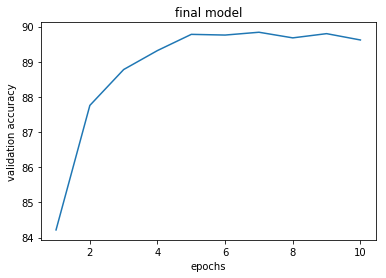

In [35]:
plt.plot(np.arange(1,num_epochs+1), val_acc_list_2)
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('final model')

In [36]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 10 epochs
Val Acc 89.68
Test Acc 87.872


In [57]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [64]:
#3 correct and 3 wrong prediction on validation set
import torch.nn.functional as F
val_text = pk.load(open('val_text.pk', 'rb'))

val_dataset = IMDbDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

model.eval()
for data, lengths, labels in val_loader:
    data_batch, length_batch, label_batch = data, lengths, labels
    outputs = F.softmax(model(data_batch, length_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    result = np.array(predicted.eq(labels.view_as(predicted)))
    correct = np.argwhere(result==1)[:,0]
    wrong = np.argwhere(result==0)[:,0]
    break

print('Correct Prediction:')
for i in correct[:3]:
    if int(label_batch[i]) == 1: label = 'pos'
    else: label = 'neg'
    
    printmd('**True label: %s**' %label)
    print(val_text[i])

print('Wrong Prediction:')
for i in wrong[[0,2,3]]: #wrong[1] is too long
    if int(label_batch[i]) == 1: label = 'pos'
    else: label = 'neg'
    
    printmd('**True label: %s**' %label)
    print(val_text[i])

Correct Prediction:


**True label: pos**

I enjoyed this movie,and after watching it,it made me wonder just how many 'Caitlin Rose's' exist in the world.How many other girls have been subjected to this sort of sexual abuse,and torment by classmates and have been too frightened to open their mouth about it? Just how threatening and cruel can teenagers be towards one another,because as this film demonstrates,who's right is not foremost important,its who is popular,and feared which manipulates the minds of youths,and influences them to allow this sort of immorality to happen.Tiffani Amber Thiessen gives a powerful performance as the rape victim,and Brian Austin Green is convincing as the guy torn between the girl he thought he loved,and his best friend.This is the kind of film that doesn't get the exposure it deserves.Remarkable,and brilliant,too good to be just a film made for TV.


**True label: pos**

Although critically maligned, Johnny Dangerously is one of the funniest movies I've ever seen. It's a movie that should be watched closely; some of the funny bits are done in passing and do not have the usual amount of attention drawn to them. For instance, keep an eye on Michael Keaton's use of the pricing gun at the pet store...and also on the documentary-style years that appear at the beginning of scenes. It's one of those rare movies where the humor hits you unexpectedly, even though you know it's a comedy. Amy Heckerling, the director, is really sharp here--If you enjoyed her better known films (Fast Times at Ridgemont High, Clueless, European Vacation, etc.,)you should give this one a look.<br /><br />Michael Keaton is extremely likable in the title role and the supporting cast (Griffin Dunne, Maureen Stapleton, Joe Piscopo, Peter Boyle) is excellent. Highly recommended.


**True label: pos**

This is a film that everyone should watch. Quite apart from raising hugely important points (while South Africa is on the road to recovery there are still many countries in similar situations now), it is superbly directed while Denzel Washington gives, in my opinion, the best performance in his career so far. Kline also gives a good performance, although perhaps not as stunning as Washington's. John Thaw also puts in a good turn as the Chief of Police.<br /><br />There are so many possible areas where a film on apartheid could fall down, but all of these have been avoided. It would be easy to simply portray white people as the bad guys and black people as the good guys, but Attenborough has not done this. Sure, there were some white characters who seemed inherently evil, such as the Captain at the Soweto uprising, but to add extra dimensions to all the characters would make the film unbearably long. Some people complain about the length of the film as it is, but I think it needs the wh

**True label: neg**

This oddity in the new DORIS DAY COLLECTION doesn't really need to be included as she is only in the film for less than 30 minutes. What she does do however, is shine when she's on screen. The near plot less movie is just an excuse to showcase some Warner contract players of the day. JANCIE RULE shows promise and it's a shame she didn't become a big star. RUTH ROMAN handles the role of the "go-getter" with aplomb. Better if this was in color. The Travis Air force base locations with some rear projection work well. What's best about the movie are some wonderful musical interludes. If you enjoyed THANK YOUR LUCKY STARS and Hollywood CANTEEN you'll like this one.


**True label: neg**

Philip. K. Dickian movie. And a decent one for that matter. Better than the Paycheck (Woo) and that abomination called Minority Report (Spielberg). But lets face it, the twisting and cheesing ending was a bit too much for me. Half way through the movie I already started to fear about such kind of ending, and I was regrettably right. But that does not mean that the film is not worth its time. No, not at all. First half (as already many here have commented) is awesome. There are some parts where you start to doubt whether the director intended to convey the message that showmanship is highly important thing in the future (we will do such kind on corny sf things because we CAN) or is it simply over combining. But the paranoia is there and feeling "out of joint" also. Good one.


**True label: pos**

This musical is decidedly mixed, and none of the elements really fit together, but it somehow manages to be mostly enjoyable. The plot contains some of the elements of Wodehouse's novel, but none of its virtues, though he co-wrote the script. The songs, though charming, have nothing to do with this particular film, and are unusually crudely squeezed into the plot, even by pre-Oklahoma standards. Burns and Allen do their usual shtick quite competently, but it misses the tone of the rest of the film by about forty IQ points.<br /><br />There are a few high points. Reginald Gardiner does good work when he remembers that this is a talkie, and stops mugging like a silent actor. And there are a few bits of writing which could only have been written by Wodehouse, though most of the film feels like the production of one of the Hollywood meetings he later parodied.
